# 导包

In [1]:
import sys 
sys.version

'3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) \n[GCC 9.3.0]'

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !unzip sohu2021_open_data_clean.zip
# !unzip chinese_L-12_H-768_A-12.zip

In [4]:
# !pip install transformers

In [5]:
import os
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
import re
from collections import Counter
import random
import json
from joblib import dump, load
from functools import partial
from datetime import datetime

from tqdm import tqdm
import numpy as np
# import tensorflow.keras as keras
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.ERROR)
from keras.metrics import top_k_categorical_accuracy, binary_accuracy
from keras.layers import *
from keras.callbacks import *
from keras.models import Model, load_model, model_from_json
import keras.backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from keras.losses import SparseCategoricalCrossentropy, binary_crossentropy
from transformers import (
    BertTokenizer,
    TFBertForPreTraining,
    TFBertModel,
)
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import class_weight
import torch
from pyhanlp import *
import jieba

from my_utils import calculate_bm25_similarity, calculate_tf_cosine_similarity, calculate_tfidf_cosine_similarity

In [6]:
tf.__version__

'2.4.1'

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11626427874791615140,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10770692224
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14261839896565559257
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1"]

In [8]:
data_path = "sohu2021_open_data_clean/"
# train_file_names = ["train.txt", "valid.txt", "round2.txt", "round3.txt"]
train_file_name = "data/shuffle_total_file.json"
text_max_length = 512
bert_path = r"chinese_L-12_H-768_A-12"

check_point_path = 'trained_model_substract_1/multi_keras_bert_sohu.weights'
weights_path = "trained_model_substract_1/multi_keras_bert_sohu_final.weights"
config_path = "trained_model_substract_1/multi_keras_bert_sohu_final.model_config.json"
result_path = "trained_model_substract_1/multi_keras_bert_sohu_test_result_final.csv"

In [9]:
bm25Model = load("bm25.bin")
bm25Model

In [10]:
# 转换bert模型，到pytorch的pd格式

In [11]:
# !transformers-cli convert --model_type bert \
#   --tf_checkpoint chinese_L-12_H-768_A-12/bert_model.ckpt \
#   --config chinese_L-12_H-768_A-12/bert_config.json \
#   --pytorch_dump_output chinese_L-12_H-768_A-12/pytorch_model.bin

# 多任务分支模型

## 构建数据迭代器

In [12]:
label_type_to_id = {'labelA':0, 'labelB':1}
label_to_id = {'0':0, '1':1}

In [13]:
# def get_text_iterator(file_path):
#     with open(file_path, 'r', encoding='utf-8') as f:
#         for line in f:
#             yield line

In [14]:
# def _transform_text(text):
#    text = text.strip().replace('\n', '。').replace('\t', '').replace('\u3000', '')
#    return re.sub(r'。+', '。', text)

In [15]:
# def get_summary(text, senc_num=20):
#     a = HanLP.extractSummary(text, 20)
#     a_ = str(a)
#     return a_[1:-1]

In [16]:
# def get_data_iterator(data_path, file_names):
#     # TODO: 随机取
#     file_iters = []
#     for file_name in file_names:
#       for category in os.listdir(data_path):
#           category_path = os.path.join(data_path, category)
#           if not os.path.isdir(category_path):
#               continue
              
#           file_path = os.path.join(category_path, file_name)
#           if not os.path.isfile(file_path):
#               continue
              
          
#           file_iter = get_text_iterator(file_path)
#           cat_source = 0
#           if category[0] == '长':
#             cat_source = 1
#           cat_target = 0
#           if category[1] == '长':
#             cat_target = 1
#           file_iters.append((file_iter, cat_source, cat_target))
        
#     while len(file_iters) > 0:
#         i = random.randrange(len(file_iters))
#         line = next(file_iters[i][0], None)
#         cat_source = file_iters[i][1]
#         cat_target = file_iters[i][2]
#         if line is None:
#             del file_iters[i]
#             continue
            
#         data = json.loads(line)

#         data['source'] = _transform_text(data['source'])
#         if len(data['source']) == 0:
#             print('source:', line, data)
#             break
# #                     continue

#         data['target'] = _transform_text(data['target'])
#         if len(data['target']) == 0:
#             print('target:', line, data)
#             break
# #                     continue

#         label_name_list = list(key for key in data.keys() if key[:5]=='label')
#         if len(label_name_list) != 1:
#             print('label_name_list:', line, data)
#             break
# #                     continue
#         label_name = label_name_list[0]
#         if data[label_name] not in label_to_id.keys():
#             print('label_name:', line, data, label_name)
#             break
# #                     continue
        
#         label_dict = {key: -1 for key in label_type_to_id.keys()}
#         label_dict[label_name] = label_to_id[data[label_name]]
#         if label_dict['labelA'] == 0:
#             label_dict['labelB'] = 0
#         if label_dict['labelB'] == 1:
#             label_dict['labelA'] = 1

#         yield data['source'], data['target'], cat_source, cat_target, label_dict['labelA'], label_dict['labelB']

In [17]:
# it = get_data_iterator(data_path, train_file_names)

In [18]:
# next(it)

In [19]:
def get_sample_num(data_path, file_names):
    count = 0
    it = get_data_iterator(data_path, file_names)
    for data in tqdm(it):
        count += 1
    return count

In [20]:
# sample_count = get_sample_num(data_path, train_file_names)
# sample_count

In [21]:
# def get_shuffle_total_file(data_path, file_names, output_file_path):
#     data_list = []
#     it = get_data_iterator(data_path, file_names)
#     for source, target, cat_source, cat_target, labelA, labelB in tqdm(it):
#         json_data = {
#             'source':source,
#             'target':target,
#             'cat_source':cat_source,
#             'cat_target':cat_target,
#             'labelA':labelA,
#             'labelB':labelB
#         }
#         data_list.append(json_data)
#     random.shuffle(data_list)
    
#     with open(output_file_path, 'w', encoding='utf-8') as output_file:
#         for json_data in data_list:
#             output_file.write(f"{json.dumps(json_data)}\n")

In [22]:
# get_shuffle_total_file(data_path, train_file_names, train_file_name)

In [23]:
def get_data_iterator(data_path, file_name):
    with open(file_name, 'r', encoding='utf-8') as f:
        for line in f:
            json_data = json.loads(line)
            yield json_data['source'], json_data['target'], json_data['cat_source'], json_data['cat_target'], json_data['labelA'], json_data['labelB']

In [24]:
it = get_data_iterator(data_path, train_file_name)

In [25]:
next(it)

('湖人120-102火箭 一觉醒来，湖人队又是一场大胜。  毫不夸张的说，这两支球队可能都是全NBA球迷最多队伍之一，两队一交手，其收视率，堪比篮圈春晚。 既然是春晚，那就不能少了节目，今儿个双方为大家伙儿准备了以下几个节目： 其一，洛杉矶小伍德，对阵休斯顿真伍德， 其二，洛杉矶詹姆斯，对阵休斯顿詹姆斯， 前三，洛杉矶塔克，对阵休斯顿塔克， 其四，理智考辛斯，对阵暴走莫里斯。  第一节末端，考神与莫里斯率先整活儿，引爆全场气氛。 话说当时詹老汉正持球背打，莫里斯使出一套坦克突进，直接将火箭球员杰肖恩-泰特老哥撵出球场。 考辛斯一看泰特倒地，大喝一声：你敢欺负我队友，这还得了？ 上前一套马保国式接化发，将莫里斯推出二米开外，并回头打算拉起倒地的泰特。 事实证明，人在生气的时候最会被激发出无限的潜能，莫里斯从被推倒地上到站起来推开考辛斯，仅仅用时不到两秒， 这么冷静就走开了！？ 这还是我们认识的考辛斯吗？？ 那速度，简直比韦德、艾弗森、TJ-福特上篮速度更快，詹老汉可能也没想到莫里斯还有这爆发力，本想拉一把，却愣是没追上。 恕技巧君直言，要是莫里斯老哥打球也能有这速度，那么顶掉小黑，出任湖人队首发控卫简直绰绰有余。  判罚结果是，双方各吃一T，大莫被驱逐。 当然，考神在场上也没待多久。 第二节刚开打，老詹突破内线，考神下手切球，一巴掌不小心切到老詹头上。 从老詹的表情大家伙儿可以看到这记如来神掌是有多痛。 尽管考神及时弥补，上前试图拉起老詹，并努力告诉裁判：“那可是我詹大爷，我怎么可能恶犯他？”，依然没逃出被驱逐的命运。  好在浓眉的发挥，又把大家伙儿的目光吸引了回来。 平日里浓眉划划水，一旦遇到自己的模板，那叫一个放开抡绝不含糊，光凭一个上半场，小伍德已经8投8中，入账21分3盖帽。 戴维斯：听说你是我的模板？来个8中8致敬一下。 另一边真伍德整个人都是崩溃的：谁特么说他是小伍德？这不是给我找麻烦么！碰别人就划水碰我就认真，这以后可咋整啊？！ 毫不夸张的说，今儿这场大胜，洛杉矶小伍德得占首功，一人直接打崩火箭队内线。  至于两个詹姆斯，反倒是手牵手好朋友，你划一桨我划一桨，洛杉矶gigi怪入账18+7+7，休斯顿大胡子拿到20+6+9，顺便带走7个失误。 泰特梦幻脚步戏耍老詹 区别在于，湖人赢球了，詹姆斯数据怎样都无所谓，火箭队输球，场边观众直呼：“哈登！醒醒！” 

In [26]:
sample_count = get_sample_num(data_path, train_file_name)
sample_count

168714it [00:14, 11514.52it/s]


168714

In [27]:
def get_sample_y(data_path, file_names):
    labelA_list = []
    labelB_list = []
    it = get_data_iterator(data_path, file_names)
    for source, target, cat_source, cat_target, labelA, labelB in tqdm(it):
        if labelA != -1:
          labelA_list.append(labelA)
        if labelB != -1:
          labelB_list.append(labelB)
    return labelA_list, labelB_list

In [28]:
# np.unique(labelA_list), labelA_list

In [29]:
labelA_list, labelB_list = get_sample_y(data_path, train_file_name)
labelA_class_weights = class_weight.compute_class_weight('balanced', np.unique(labelA_list), np.array(labelA_list))
labelB_class_weights = class_weight.compute_class_weight('balanced', np.unique(labelB_list), np.array(labelB_list))
labelA_class_weights, labelB_class_weights

168714it [00:14, 11933.51it/s]
/data1/wangchenyue/zsd/code/sohu2021/conda_env/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 1 ... 1 0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/data1/wangchenyue/zsd/code/sohu2021/conda_env/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 1 ... 1 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


(array([0.94664122, 1.05973338]), array([0.56295201, 4.47127937]))

In [30]:
tokenizer = BertTokenizer.from_pretrained(bert_path)

In [31]:
def _get_indices(text, text_pair=None):
    return tokenizer.encode_plus(text=text,
                            text_pair=text_pair,
                            max_length=text_max_length, 
                            add_special_tokens=True, 
                            padding='max_length', 
#                             truncation_strategy='longest_first', 
                            truncation=True,
#                                          return_tensors='tf',
                            return_token_type_ids=True
                            )

In [32]:
def get_keras_bert_iterator(data_path, file_names, tokenizer):
    while True:
        data_it = get_data_iterator(data_path, file_names)
        for source, target, cat_source, cat_target, labelA, labelB in data_it:
            data_source = _get_indices(text=source)
            data_target = _get_indices(text=target)
#             print(indices, type(indices), len(indices))
            seg_source = jieba.lcut(source)
            seg_target = jieba.lcut(target)
            bm25 = calculate_bm25_similarity(bm25Model, seg_source, seg_target)
            tf_cosine = calculate_tf_cosine_similarity(seg_source, seg_target)
            tfidf_cosine = calculate_tfidf_cosine_similarity(seg_source, seg_target, bm25Model.idf)
            yield data_source['input_ids'], data_source['token_type_ids'], data_source['attention_mask'], \
                  data_target['input_ids'], data_target['token_type_ids'], data_target['attention_mask'], \
                  bm25, tf_cosine, tfidf_cosine, \
                  cat_source, cat_target, \
                  labelA, labelB

In [33]:
it = get_keras_bert_iterator(data_path, train_file_name, tokenizer)

In [34]:
# next(it)

In [35]:
def batch_iter(data_path, file_names, tokenizer, batch_size=64, shuffle=True):
    """生成批次数据"""
    keras_bert_iter = get_keras_bert_iterator(data_path, file_names, tokenizer)
    while True:
        data_list = []
        for _ in range(batch_size):
            data = next(keras_bert_iter)
#             print(data)
            data_list.append(data)
        if shuffle:
            random.shuffle(data_list)
#         print(data_list)
        
        input_ids_texta_list = []
        token_type_ids_texta_list = []
        attention_mask_texta_list = []
        input_ids_textb_list = []
        token_type_ids_textb_list = []
        attention_mask_textb_list = []
        bm25_list = []
        tf_cosine_list = []
        tfidf_cosine_list = []
        cat_texta_list = []
        cat_textb_list = []
        labelA_list = []
        labelB_list = []
        for data in data_list:
            input_ids_texta, token_type_ids_texta, attention_mask_texta, \
            input_ids_textb, token_type_ids_textb, attention_mask_textb, \
            bm25, tf_cosine, tfidf_cosine, \
            cat_texta, cat_textb, \
            labelA, labelB = data
#             print(indices, type(indices))
            input_ids_texta_list.append(input_ids_texta)
            token_type_ids_texta_list.append(token_type_ids_texta)
            attention_mask_texta_list.append(attention_mask_texta)
            input_ids_textb_list.append(input_ids_textb)
            token_type_ids_textb_list.append(token_type_ids_textb)
            attention_mask_textb_list.append(attention_mask_textb)
            bm25_list.append(bm25)
            tf_cosine_list.append(tf_cosine)
            tfidf_cosine_list.append(tfidf_cosine)
            cat_texta_list.append(cat_texta)
            cat_textb_list.append(cat_textb)
            labelA_list.append(labelA)
            labelB_list.append(labelB)

        yield [np.array(input_ids_texta_list), np.array(token_type_ids_texta_list), np.array(attention_mask_texta_list), 
               np.array(input_ids_textb_list), np.array(token_type_ids_textb_list), np.array(attention_mask_textb_list), 
               np.array(bm25_list), np.array(tf_cosine_list), np.array(tfidf_cosine_list),
               np.array(cat_texta_list), np.array(cat_textb_list)], \
            [np.array(labelA_list, dtype=np.int32), np.array(labelB_list, dtype=np.int32)]

In [36]:
it = batch_iter(data_path, train_file_name, tokenizer, batch_size=2)

In [37]:
next(it)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.652 seconds.
Prefix dict has been built successfully.


([array([[ 101, 3959,  782, ..., 4197, 8024,  102],
         [ 101, 3885, 7178, ...,    0,    0,    0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0]]),
  array([[ 101, 3959,  782, ..., 8043, 6821,  102],
         [ 101,  707, 6818, ..., 1402,  510,  102]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]]),
  array([0.27506248, 0.        ]),
  array([0.66811661, 0.02466151]),
  array([0.2846926, 0.       ]),
  array([1, 0]),
  array([1, 1])],
 [array([0, 0], dtype=int32), array([0, 0], dtype=int32)])

In [38]:
def get_test_data_iterator(data_path, file_name):
  # print(data_path)
  for category in os.listdir(data_path):
    category_path = os.path.join(data_path, category)
    # print(category_path)
    if not os.path.isdir(category_path):
      # print(f"{category_path} not dir")
      continue
        
    file_path = os.path.join(category_path, file_name)
    # print(file_path)
    if not os.path.isfile(file_path):
      # print(f"{file_path} not file")
      continue
    
    with open(file_path, 'r', encoding='utf-8') as f:
      for line in f:
        # print(line)
        data = json.loads(line)
        
        data['source'] = _transform_text(data['source'])
        if len(data['source']) == 0:
          print('source:', line, data)
          break
            
        data['target'] = _transform_text(data['target'])
        if len(data['target']) == 0:
          print('target:', line, data)
          break

        cat_source = 0
        if category[0] == '长':
          cat_source = 1
        cat_target = 0
        if category[1] == '长':
          cat_target = 1
            
        yield data['source'], data['target'], cat_source, cat_target, data['id']

In [39]:
def get_test_keras_bert_iterator(data_path, file_name):
  it = get_test_data_iterator(data_path, file_name)
  for source, target, cat_source, cat_target, id in it:
    data_source = _get_indices(text=source)
    data_target = _get_indices(text=target)
    
    seg_source = jieba.lcut(source)
    seg_target = jieba.lcut(target)
    bm25 = calculate_bm25_similarity(bm25Model, seg_source, seg_target)
    tf_cosine = calculate_tf_cosine_similarity(seg_source, seg_target)
    tfidf_cosine = calculate_tfidf_cosine_similarity(seg_source, seg_target, bm25Model.idf)
    
    yield data_source['input_ids'], data_source['token_type_ids'], data_source['attention_mask'], \
          data_target['input_ids'], data_target['token_type_ids'], data_target['attention_mask'], \
          bm25, tf_cosine, tfidf_cosine, \
          cat_source, cat_target, \
          id

In [40]:
def get_test_iterator(data_path, file_name):
  it = get_test_keras_bert_iterator(data_path, file_name)
  for input_ids_texta, token_type_ids_texta, attention_mask_texta, \
      input_ids_textb, token_type_ids_textb, attention_mask_textb, \
      bm25, tf_cosine, tfidf_cosine, \
      cat_source, cat_target, \
      id in it:
    yield [np.array([input_ids_texta]), np.array([token_type_ids_texta]), np.array([attention_mask_texta]), 
           np.array([input_ids_textb]), np.array([token_type_ids_textb]), np.array([attention_mask_textb]), 
           np.array([bm25]), np.array([tf_cosine]), np.array([tfidf_cosine]),
           np.array([cat_source]), np.array([cat_target])], id

In [41]:
it = get_test_iterator(data_path, "test_with_id.txt")
# next(it)

In [42]:
def save_test_result(model, result_file):
  it = get_test_iterator(data_path, "test_with_id.txt")
#   print("      ", end="")
#   count = 0
  with open(result_file, 'w', encoding='utf-8') as f:
    f.write(f"id,label\n")
    for data, id in tqdm(it):
      predict = model.predict(data)
      if id[-1] == 'a':
        predict_cls = 1 if predict[0][0][0] > 0.5 else 0
      elif id[-1] == 'b':
        predict_cls = 1 if predict[1][0][0] > 0.5 else 0
      else:
        print(id)
        continue
      f.write(f"{id},{predict_cls}\n")
#       count += 1
#       print(f"\b\b\b\b\b\b{count}", end="")

## 定义模型

In [43]:
def variant_focal_loss(gamma=2., alpha=0.5, rescale = False):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        # print(y_true)
        """
        Focal loss for bianry-classification
        FL(p_t)=-rescaled_factor*alpha_t*(1-p_t)^{gamma}log(p_t)
        
        Notice: 
        y_pred is probability after sigmoid

        Arguments:
            y_true {tensor} -- groud truth label, shape of [batch_size, 1]
            y_pred {tensor} -- predicted label, shape of [batch_size, 1]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})  
            alpha {float} -- (default: {0.5})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9  
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        model_out = tf.clip_by_value(y_pred, epsilon, 1.-epsilon)  # to advoid numeric underflow
        
        # compute cross entropy ce = ce_0 + ce_1 = - (1-y)*log(1-y_hat) - y*log(y_hat)
        ce_0 = tf.multiply(tf.subtract(1., y_true), -tf.math.log(tf.subtract(1., model_out)))
        ce_1 = tf.multiply(y_true, -tf.math.log(model_out))

        # compute focal loss fl = fl_0 + fl_1
        # obviously fl < ce because of the down-weighting, we can fix it by rescaling
        # fl_0 = -(1-y_true)*(1-alpha)*((y_hat)^gamma)*log(1-y_hat) = (1-alpha)*((y_hat)^gamma)*ce_0
        fl_0 = tf.multiply(tf.pow(model_out, gamma), ce_0)
        fl_0 = tf.multiply(1.-alpha, fl_0)
        # fl_1= -y_true*alpha*((1-y_hat)^gamma)*log(y_hat) = alpha*((1-y_hat)^gamma*ce_1
        fl_1 = tf.multiply(tf.pow(tf.subtract(1., model_out), gamma), ce_1)
        fl_1 = tf.multiply(alpha, fl_1)
        fl = tf.add(fl_0, fl_1)
        f1_avg = tf.reduce_mean(fl)
        
        if rescale:
            # rescale f1 to keep the quantity as ce
            ce = tf.add(ce_0, ce_1)
            ce_avg = tf.reduce_mean(ce)
            rescaled_factor = tf.divide(ce_avg, f1_avg + epsilon)
            f1_avg = tf.multiply(rescaled_factor, f1_avg)
        
        return f1_avg
    
    return focal_loss_fixed

In [44]:
def f1_loss(y_true, y_pred):
    # y_true:真实标签0或者1；y_pred:为正类的概率
    loss = 2 * tf.reduce_sum(y_true * y_pred) / tf.reduce_sum(y_true + y_pred) + K.epsilon()
    return -loss

In [45]:
def transform_y(y_true, y_pred):
    mask_value = tf.constant(-1)
    mask_y_true = tf.not_equal(tf.cast(y_true, dtype=tf.int32), tf.cast(mask_value, dtype=tf.int32))
#     print(f"mask_y_true:{mask_y_true}")
#     y_true_ = tf.cond(tf.equal(y_true, mask_value), lambda: 0, lambda: y_true)
    y_true_ = tf.cast(y_true, dtype=tf.int32) * tf.cast(mask_y_true, dtype=tf.int32)
    y_pred_ = tf.cast(y_pred, dtype=tf.float32) * tf.cast(mask_y_true, dtype=tf.float32)
#     print(f"y_true_:{y_true_}, y_pred_:{y_pred_}")
    
    return tf.cast(y_true_, dtype=tf.float32), tf.cast(y_pred_, dtype=tf.float32)

In [46]:
def my_binary_crossentropy(y_true, y_pred, class_weights):
#     print(f"y_true: {y_true}")
    mask_value = tf.constant(-1)
#     mask_y_true = tf.not_equal(tf.cast(y_true, dtype=tf.int32), tf.cast(mask_value, dtype=tf.int32))
    
#     mask = tf.zeros(shape=y_true.shape)
    zero_value = tf.constant(0)
#     print(f"cond0: {tf.equal(y_true, mask_value)}")
#     print(f"cond1: {tf.equal(y_true, zero_value)}")
#     weight = [tf.cond(tf.equal(x, mask_value), lambda: 0, tf.cond(tf.equal(x, zero_value), lambda: class_weights[0], lambda: class_weights[1])) for x in y_true]
    weight = [0 if x[0]==-1 else class_weights[x[0]] for x in y_true]
#     print(f"weight: {weight}")
    
    bin_loss = binary_crossentropy(y_true, y_pred)
#     print(f"bin_loss: {bin_loss}")
#     f1_loss = f1_loss(y_true, y_pred)
#     loss = bin_loss + f1_loss
    
    loss_ = tf.cast(bin_loss, dtype=tf.float32) * tf.cast(weight, dtype=tf.float32)
#     print(f"loss_: {loss_}")

    return loss_

In [47]:
def my_binary_crossentropy_A(y_true, y_pred):
    return my_binary_crossentropy(y_true, y_pred, labelA_class_weights)

def my_binary_crossentropy_B(y_true, y_pred):
    return my_binary_crossentropy(y_true, y_pred, labelB_class_weights)

In [48]:
def tarnsform_metrics(y_true, y_pred):
    y_true_, y_pred_ = y_true.numpy(), y_pred.numpy()
    for i in range(y_true_.shape[0]):
        for j in range(y_true_.shape[1]):
            if y_true_[i][j] == -1:
                y_true_[i][j] = 0
                y_pred_[i][j] = random.choice([0, 1])
            if y_pred_[i][j] > 0.5:
                y_pred_[i][j] = 1
            else:
                y_pred_[i][j] = 0
    return y_true_, y_pred_

In [49]:
def my_binary_accuracy(y_true, y_pred):
#     print("my_binary_accuracy")
#     print(f"y_true:{y_true}, y_pred:{y_pred}")
    
    y_true_, y_pred_ = tarnsform_metrics(y_true, y_pred)
#     print(f"y_true_:{y_true_}, y_pred_:{y_pred_}")

    accuracy = binary_accuracy(y_true_, y_pred_)
    return accuracy

In [50]:
def my_f1_score(y_true, y_pred):
#     print("my_f1_score")
#     print(f"y_true:{y_true}, y_pred:{y_pred}")
    
    y_true_, y_pred_ = tarnsform_metrics(y_true, y_pred)
#     print(f"y_true_:{y_true_}, y_pred_:{y_pred_}")

    return f1_score(y_true_, y_pred_, average='macro')

In [51]:
def get_model():
    K.clear_session()
    
    bert_model = TFBertModel.from_pretrained(bert_path, from_pt=True, trainable=True)
    for l in bert_model.layers:
        l.trainable = True
 
    input_ids_texta = Input(shape=(None,), dtype='int32', name='input_ids_texta')
    input_token_type_ids_texta = Input(shape=(None,), dtype='int32', name='input_token_type_ids_texta')
    input_attention_mask_texta = Input(shape=(None,), dtype='int32', name='input_attention_mask_texta')
    input_ids_textb = Input(shape=(None,), dtype='int32', name='input_ids_textb')
    input_token_type_ids_textb = Input(shape=(None,), dtype='int32', name='input_token_type_ids_textb')
    input_attention_mask_textb = Input(shape=(None,), dtype='int32', name='input_attention_mask_textb')
    input_token_type_ids_textb = Input(shape=(None,), dtype='int32', name='input_token_type_ids_textb')
    input_bm25 = Input(shape=(1), dtype='float32', name='input_bm25')
    input_tf_cosine = Input(shape=(1), dtype='float32', name='input_tf_cosine')
    input_tfidf_cosine = Input(shape=(1), dtype='float32', name='input_tfidf_cosine')
    input_cat_texta = Input(shape=(1), dtype='float32', name='input_cat_texta')
    input_cat_textb = Input(shape=(1), dtype='float32', name='input_cat_textb')
 
    bert_output_texta = bert_model({'input_ids':input_ids_texta, 'token_type_ids':input_token_type_ids_texta, 'attention_mask':input_attention_mask_texta}, return_dict=False, training=True)
    projection_logits_texta = bert_output_texta[0]
    bert_cls_texta = Lambda(lambda x: x[:, 0])(projection_logits_texta) # 取出[CLS]对应的向量用来做分类

    bert_output_textb = bert_model({'input_ids':input_ids_textb, 'token_type_ids':input_token_type_ids_textb, 'attention_mask':input_attention_mask_textb}, return_dict=False, training=True)
    projection_logits_textb = bert_output_textb[0]
    bert_cls_textb = Lambda(lambda x: x[:, 0])(projection_logits_textb) # 取出[CLS]对应的向量用来做分类
    
    subtracted = Subtract()([bert_cls_texta, bert_cls_textb])
    cos = Dot(axes=1, normalize=True)([bert_cls_texta, bert_cls_textb]) # dot=1按行点积，normalize=True输出余弦相似度

    bert_cls = concatenate([bert_cls_texta, bert_cls_textb, subtracted, cos, input_bm25, input_tf_cosine, input_tfidf_cosine, input_cat_texta, input_cat_textb], axis=-1)
    
    dense_A_0 = Dense(256, activation='relu')(bert_cls)
    dropout_A_0 = Dropout(0.2)(dense_A_0)
    dense_A_1 = Dense(32, activation='relu')(dropout_A_0)
    dropout_A_1 = Dropout(0.2)(dense_A_1)
    output_A = Dense(1, activation='sigmoid', name='output_A')(dropout_A_1)
    
    dense_B_0 = Dense(256, activation='relu')(bert_cls)
    dropout_B_0 = Dropout(0.2)(dense_B_0)
    dense_B_1 = Dense(32, activation='relu')(dropout_B_0)
    dropout_B_1 = Dropout(0.2)(dense_B_1)
    output_B = Dense(1, activation='sigmoid', name='output_B')(dropout_B_1)
 
    model = Model([input_ids_texta, input_token_type_ids_texta, input_attention_mask_texta, input_ids_textb, input_token_type_ids_textb, input_attention_mask_textb, input_bm25, input_tf_cosine, input_tfidf_cosine, input_cat_texta, input_cat_textb], [output_A, output_B])
    model.compile(
#                   loss=my_binary_crossentropy,
                  loss={
                      'output_A':my_binary_crossentropy_A,
                      'output_B':my_binary_crossentropy_B,
                  },
#                   loss='binary_crossentropy',
#                   loss=binary_crossentropy,
                  optimizer=Adam(1e-5),    #用足够小的学习率
                  metrics=[my_binary_accuracy, my_f1_score]
#                   metrics='accuracy'
                 )
    print(model.summary())
    return model

In [52]:
early_stopping = EarlyStopping(monitor='loss', patience=3)   #早停法，防止过拟合
plateau = ReduceLROnPlateau(monitor="loss", verbose=1, factor=0.5, patience=2) #当评价指标不在提升时，减少学习率
checkpoint = ModelCheckpoint(check_point_path, monitor='loss', verbose=2, save_best_only=True, save_weights_only=True) #保存最好的模型
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{datetime.now().strftime('%Y%m%d-%H%M%S')}", update_freq=500)

## 模型训练

In [53]:
def get_step(sample_count, batch_size):
    step = sample_count // batch_size
    if sample_count % batch_size != 0:
        step += 1
    return step

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_attention_mask_texta (Inp [(None, None)]       0                                            
__________________________________________________________________________________________________
input_ids_texta (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
input_token_type_ids_texta (Inp [(None, None)]       0                                            
__________________________________________________________________________________________________
input_attention_mask_textb (Inp [(None, None)]       0                                            
______________________________________________________________________________________________

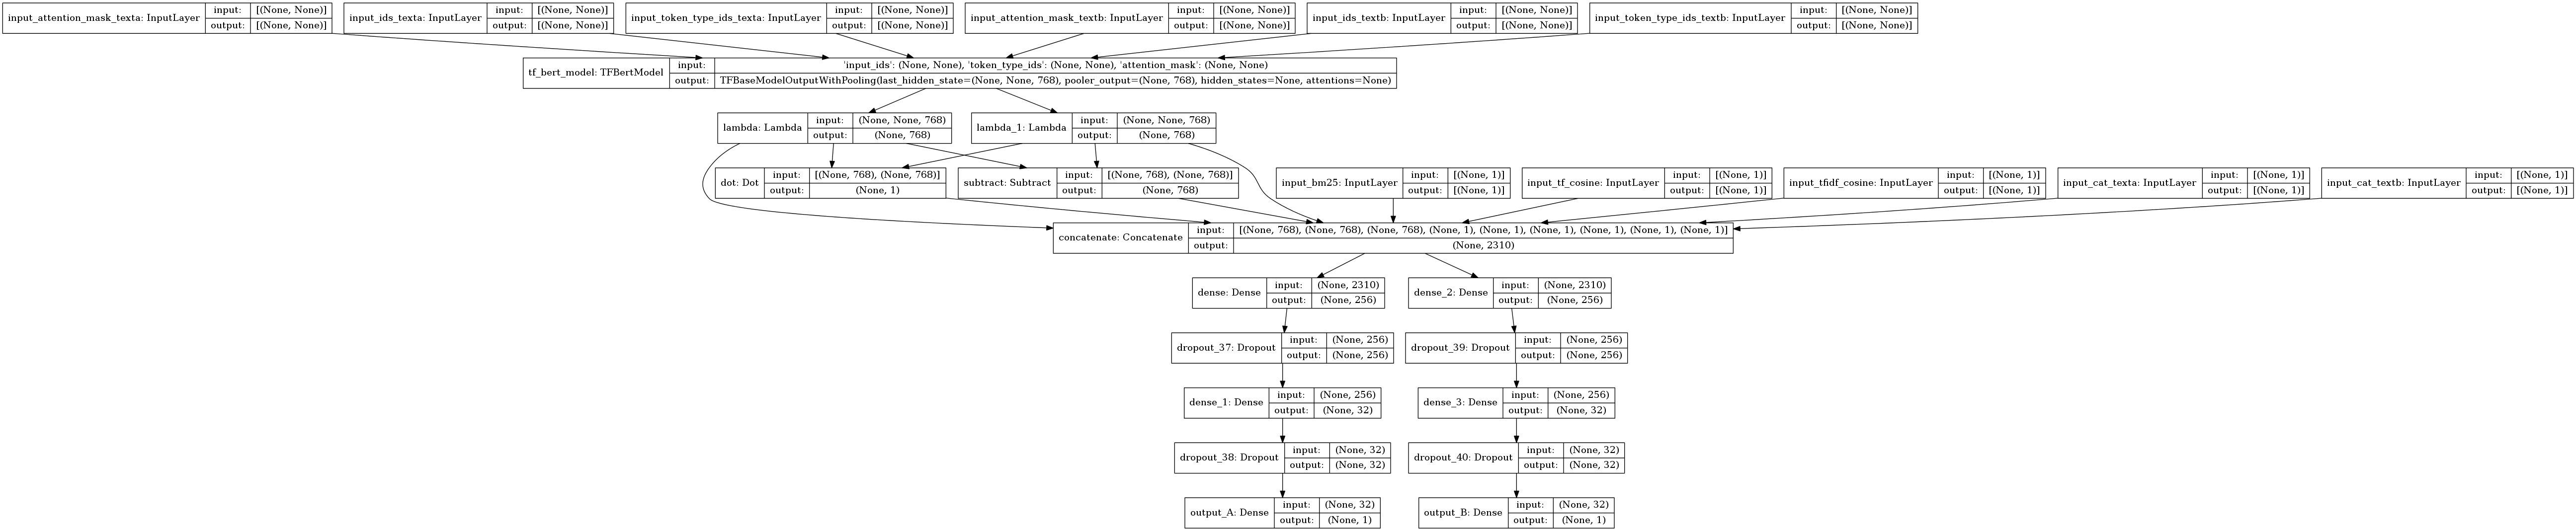

In [54]:
model = get_model()
plot_model(model, "keras_bert_transformers_two_text_input_SubStract_bm25cosine_1.png", show_shapes=True)

In [55]:
model.load_weights(check_point_path)

In [ ]:
# batch_size = 2
# epochs = 10

# train_dataset_iterator = batch_iter(data_path, train_file_name, tokenizer, batch_size)
# train_step = get_step(sample_count, batch_size)

# model.fit(
#     train_dataset_iterator,
#     # steps_per_epoch=10,
#     steps_per_epoch=train_step,
#     epochs=epochs,
# #       validation_data=dev_dataset_iterator,
#   # validation_steps=2,
# #       validation_steps=dev_step,
# #     validation_split=0.2,
# #     class_weight={
# #         'output_A':labelA_class_weights,
# #         'output_B':labelB_class_weights,
# #     },
#     callbacks=[early_stopping, plateau, checkpoint, tensorboard_callback],
#     verbose=1
# )

# model.save_weights(weights_path)
# # model_json = model.to_json()
# # with open(config_path, 'w', encoding='utf-8') as file:
# #     file.write(model_json)

# save_test_result(model, result_path)

In [ ]:
# model = get_model()
# # with open(config_path, 'r', encoding='utf-8') as json_file:
# #     loaded_model_json = json_file.read()
# # model = model_from_json(loaded_model_json)
# model.load_weights(check_point_path)
# save_test_result(model, "trained_model_substract_1/multi_keras_bert_sohu_test_result_epoch6.csv")

In [ ]:
batch_size = 2
epochs = 10

train_dataset_iterator = batch_iter(data_path, train_file_name, tokenizer, batch_size)
train_step = get_step(sample_count, batch_size)

for epoch in range(epochs):
    model.fit(
        train_dataset_iterator,
        steps_per_epoch=train_step,
        epochs=1,
        callbacks=[early_stopping, plateau, checkpoint, tensorboard_callback],
        verbose=1
    )

    model.save_weights(weights_path)

    save_test_result(model, f"{result_path}.epoch_{epoch}.csv")

# 模型加载及测试

## load_weights

## load_model